In [15]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

# Chargement des données déjà prétraitées
Xtest = pd.read_csv('../../data/data_preprocessed/data_resampled_Xtest.csv')
Xtrain = pd.read_csv('../../data/data_preprocessed/data_resampled_Xtrain.csv')
ytest = pd.read_csv('../../data/data_preprocessed/data_resampled_ytest.csv')
ytrain = pd.read_csv('../../data/data_preprocessed/data_resampled_ytrain.csv')


# Conversion éventuelle des DataFrame y en Series
if isinstance(ytrain, pd.DataFrame):
    ytrain = ytrain.iloc[:, 0]
if isinstance(ytest, pd.DataFrame):
    ytest = ytest.iloc[:, 0]


X_sample, _, y_sample, _ = train_test_split(
    Xtrain, ytrain,
    train_size=0.2,
    stratify=ytrain,
    random_state=42
)

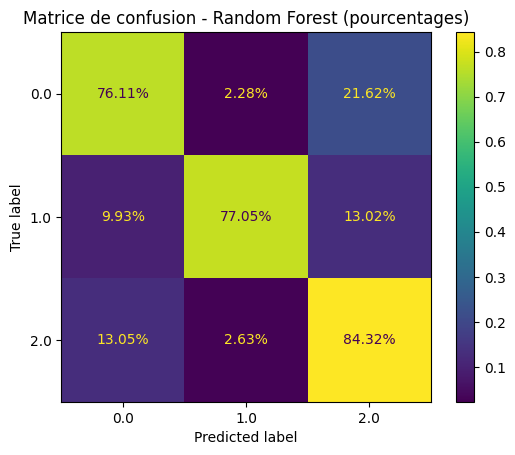

In [10]:
final_rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=40,
    min_samples_split=2,
    random_state=42
)
final_rf.fit(Xtrain, ytrain)

# Prédictions sur le jeu de test
y_pred = final_rf.predict(Xtest)

# Calcul de la matrice de confusion normalisée par ligne
cm = confusion_matrix(ytest, y_pred, normalize='true')

# Affichage de la matrice de confusion avec pourcentages (2 décimales)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_rf.classes_)
disp.plot(values_format='.2%')
plt.title("Matrice de confusion - Random Forest (pourcentages)")
plt.show()

/home/laureal/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:39:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


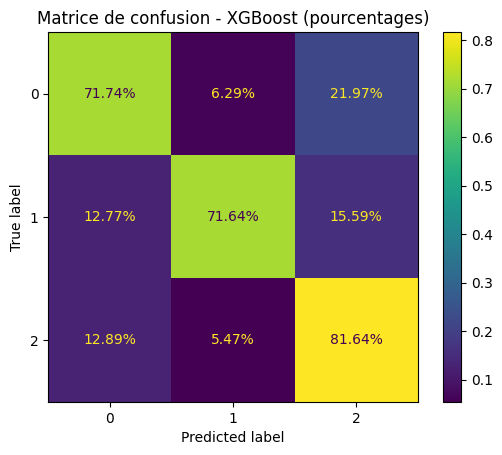

In [14]:
# Entraînement du modèle final XGBoost avec les hyperparamètres donnés
final_xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    max_depth=100,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=1.0,
    learning_rate=0.3,
    n_estimators=100
)
final_xgb.fit(Xtrain, ytrain)

# Prédictions sur le jeu de test
ypred = final_xgb.predict(Xtest)

# Calcul de la matrice de confusion normalisée par ligne
cm = confusion_matrix(ytest, ypred, normalize='true')

# Affichage de la matrice de confusion avec pourcentages (2 décimales)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_xgb.classes_)
disp.plot(values_format='.2%')
plt.title("Matrice de confusion - XGBoost (pourcentages)")
plt.show()


In [ ]:
# Définition du modèle LightGBM
lgbm = lgb.LGBMClassifier(random_state=42)

# Grille d'hyperparamètres à tester
param_grid = {
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'min_child_samples': [10, 20, 30]
}

# Recherche d'hyperparamètres avec HalvingGridSearchCV
search = HalvingGridSearchCV(
    lgbm,
    param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=3,
    verbose=1
)

search.fit(X_sample, y_sample)

print("Meilleurs hyperparamètres trouvés :")
print(search.best_params_)
print(f"Score sur le train : {search.best_score_:.3f}")

# Prédictions sur le jeu de test
y_pred = search.predict(Xtest)

# Calcul de la matrice de confusion normalisée par ligne
cm = confusion_matrix(ytest, y_pred, normalize='true')

# Affichage de la matrice de confusion avec pourcentages (2 décimales)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=search.classes_)
disp.plot(values_format='.2%')
plt.title("Matrice de confusion - LightGBM (pourcentages)")
plt.show()


n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 5631
max_resources_: 456132
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 243
n_resources: 5631
Fitting 3 folds for each of 243 candidates, totalling 729 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 3754, number of used features: 11
[LightGBM] [Info] Start training from score -1.103686
[LightGBM] [Info] Start training from score -1.103686
[LightGBM] [Info] Start training from score -1.088541
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Numb

KeyboardInterrupt: 